In [1]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import itertools
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import *
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.initializers import glorot_uniform

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
#parameters
classes = 4
cc = 200
IMAGE_SIZE = [256,256]
TH = 512
H, W = 256, 256
channel = 3
num_class = 3
batch_size = 64
class_names = ["glioma", "meningioma", "notumor", "pituitary"]
LR = 1e-6

# Helping Function For Augmentation

In [3]:
def load_aug_data(path, split=0.1):
    images = shuffle(glob(os.path.join(path, "*", "*.jpg")))
    

    return images

In [4]:
#read the data
def load_data(path, types):
    images = sorted(glob(os.path.join(path, f"{types}/*")))
    return images

In [5]:
#create folder for save augmented images
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
#augmentation
def augment_data(images, save_path, augment=True):

    for x in tqdm(images, total=(len(images))):
        name = x.split("/")[-1].split(".")
        image_name = name[0]
        image_ext = name[1]
        
        
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        
        if augment == True:
            aug = RandomRotate90(p=1.0)
            augemented = aug(image=x)
            x1 = augemented["image"]
            
            aug = HorizontalFlip(p=1.0)
            augemented = aug(image=x)
            x2 = augemented["image"]
            
            aug = VerticalFlip(p=1.0)
            augemented = aug(image=x)
            x3 = augemented["image"]
            
            save_images = [x, x1, x2, x3]
        else:
            save_images = [x]
        
        idx = 0
        for i in save_images:
            i = cv2.resize(i, (W, H))
            
            temp_img_name = f"{image_name}_{idx}.{image_ext}"
            
            image_path = os.path.join(save_path, temp_img_name)
            
            cv2.imwrite(image_path, i)
            idx += 1

# Data Pipeline Function

In [7]:
def process_image(path):
    #decode the path
    path = path.decode()
    #read image
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    #resize the image
    image = cv2.resize(image, [256, 256])
    #scale the image
    image = image / 255.0
    #change the data type of image
    image = image.astype(np.float32)

    #labeling the image
    class_name = path.split("/")[-2]
    class_idx = class_names.index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)

    return image, class_idx

In [8]:
def parse(path):
    image, labels = tf.numpy_function(process_image, [path], (tf.float32, tf.int32))
    labels = tf.one_hot(labels, 4)
    image.set_shape([256, 256, 3])
    labels.set_shape(4)
  
    return image, labels

In [9]:
#tensorflow dataset
def tf_dataset(images, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((images))
    dataset = dataset.map(parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(8)
    return dataset

In [10]:
#callbacks parameter //paths
model_path = "vgg_for_brain_tumor-v2.h5"
csv_path = "brain_tumor_2.csv"

In [11]:
path = "/kaggle/input/brain-tumor-mri-dataset/Training"
types = ['glioma','meningioma','notumor','pituitary']

# Model

In [12]:
model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
#freeze training existing layer
for layer in model.layers:
  layer.trainable = False

In [14]:
#build our layers
x = layers.Flatten()(model.output)

In [15]:
#set last layer
prediction_layer = layers.Dense(4, activation='softmax' )(x)
#declare the model
model = Model(inputs=model.input, outputs=prediction_layer)

In [16]:
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    CSVLogger(csv_path),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
]

In [17]:
#compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data Augmentation

In [18]:
#create augment folder
create_dir("/kaggle/working/train/"+f'{types[0]}')
create_dir("/kaggle/working/train/"+f'{types[1]}')
create_dir("/kaggle/working/train/"+f'{types[2]}')
create_dir("/kaggle/working/train/"+f'{types[3]}')

In [19]:
images_1 = load_data(path, types[0])
images_2 = load_data(path, types[1])
images_3 = load_data(path, types[2])
images_4 = load_data(path, types[3])

In [20]:
print(f'Original Images : {len(images_1)}')
print(f'Original Images : {len(images_2)}')
print(f'Original Images : {len(images_3)}')
print(f'Original Images : {len(images_4)}')

Original Images : 1321
Original Images : 1339
Original Images : 1595
Original Images : 1457


In [21]:
save_path_1 = "/kaggle/working/train/"+f'{types[0]}'
save_path_2 = "/kaggle/working/train/"+f'{types[1]}'
save_path_3 = "/kaggle/working/train/"+f'{types[2]}'
save_path_4 = "/kaggle/working/train/"+f'{types[3]}'

In [22]:
augment_data(images_1, save_path_1, augment=True)
augment_data(images_2, save_path_2, augment=True)
augment_data(images_3, save_path_3, augment=True)
augment_data(images_4, save_path_4, augment=True)

100%|██████████| 1457/1457 [00:26<00:00, 55.24it/s]


In [23]:
augmented_path = "/kaggle/working/train/"
glioma = load_data(augmented_path, types[0])
meningioma = load_data(augmented_path, types[1])
notumor = load_data(augmented_path, types[2])
pituitary = load_data(augmented_path, types[3])

In [24]:
print(f'Original Images : {len(glioma)}')
print(f'Original Images : {len(meningioma)}')
print(f'Original Images : {len(notumor)}')
print(f'Original Images : {len(pituitary)}')

Original Images : 5284
Original Images : 5356
Original Images : 6380
Original Images : 5828


Text(0.5, 0, 'pituitary')

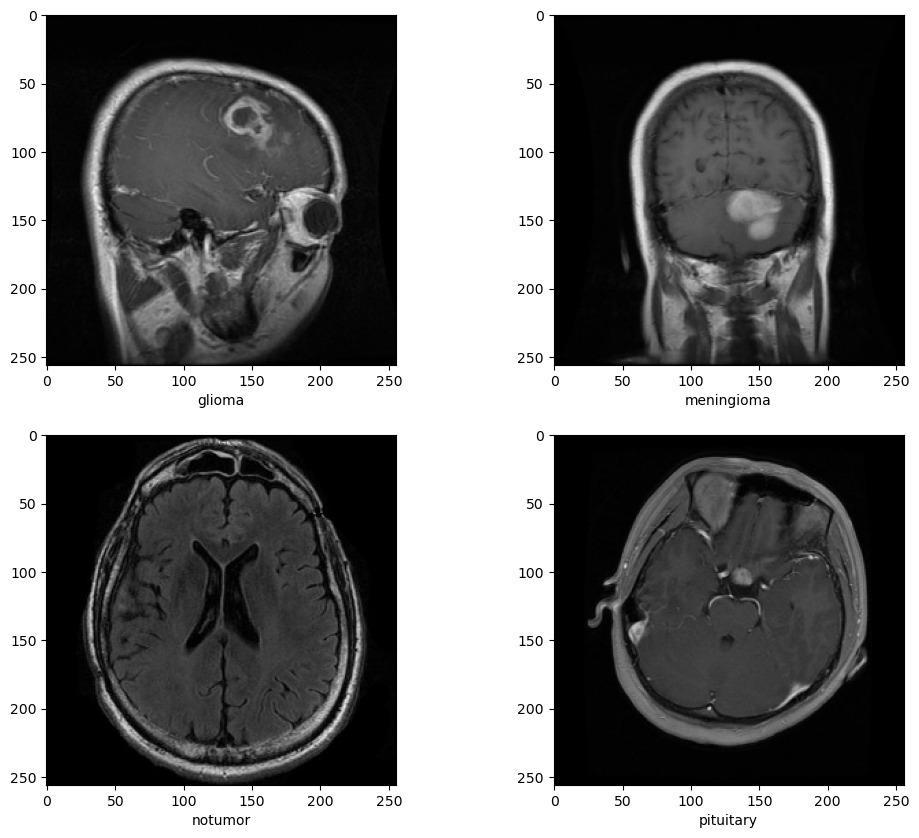

In [25]:
img1 = cv2.imread(glioma[4000], cv2.IMREAD_COLOR)
img2 = cv2.imread(meningioma[4000], cv2.IMREAD_COLOR)
img3 = cv2.imread(notumor[4000], cv2.IMREAD_COLOR)
img4 = cv2.imread(pituitary[4000], cv2.IMREAD_COLOR)

fig, ax = plt.subplots(2,2, figsize=(12,10))
ax[0,0].imshow(img1)
ax[0,0].set_xlabel("glioma")
ax[0,1].imshow(img2)
ax[0,1].set_xlabel("meningioma")
ax[1,0].imshow(img3)
ax[1,0].set_xlabel("notumor")
ax[1,1].imshow(img4)
ax[1,1].set_xlabel("pituitary")

In [26]:
#after augmented
test_path = "/kaggle/input/brain-tumor-mri-dataset/Training"
train_path = "/kaggle/working/train/"

# Data Pipeline

In [27]:
x_train = load_aug_data(train_path)
x_test = load_aug_data(test_path)
print(f"Train:{len(x_train)} - Test:{len(x_test)}")

Train:22848 - Test:5712


In [28]:
#tensor dataset
train_df = tf_dataset(x_train)
test_df = tf_dataset(x_test)

In [29]:
model.fit(
    train_df,
    validation_data=test_df,
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/20
357/357 [==============================] - ETA: 0s - loss: 0.3486 - accuracy: 0.8750
Epoch 1: val_loss improved from inf to 0.14332, saving model to vgg_for_brain_tumor-v2.h5
357/357 [==============================] - 171s 430ms/step - loss: 0.3486 - accuracy: 0.8750 - val_loss: 0.1433 - val_accuracy: 0.9489 - lr: 0.0010
Epoch 2/20
357/357 [==============================] - ETA: 0s - loss: 0.1529 - accuracy: 0.9457
Epoch 2: val_loss improved from 0.14332 to 0.06939, saving model to vgg_for_brain_tumor-v2.h5
357/357 [==============================] - 152s 426ms/step - loss: 0.1529 - accuracy: 0.9457 - val_loss: 0.0694 - val_accuracy: 0.9797 - lr: 0.0010
Epoch 3/20
357/357 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9610
Epoch 3: val_loss did not improve from 0.06939
357/357 [==============================] - 152s 424ms/step - loss: 0.1153 - accuracy: 0.9610 - val_loss: 0.0856 - val_accuracy: 0.9701 - lr: 0.0010
Epoch 4/20
357/357 [=================

In [30]:
model.evaluate(test_df)

90/90 [==============================] - 31s 340ms/step - loss: 0.0026 - accuracy: 0.9995


[0.0025726344902068377, 0.9994747638702393]

# Explanation

In [31]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [32]:
#preprocess function
def process_img(path):
    #read image
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    #resize the image
    image = cv2.resize(image, [256, 256])
    #scale the image
    image = image / 255.0
    #change the data type of image
    image = image.astype(np.float32)
    
    return image

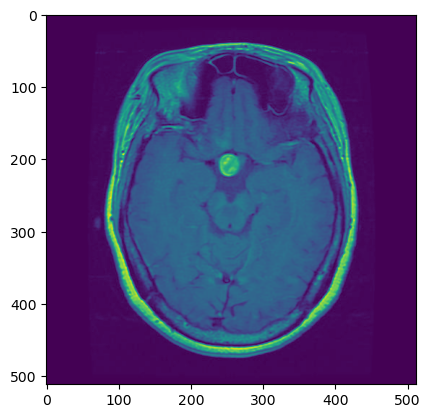

In [33]:
path = "/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0018.jpg"
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
image = process_img(path)

In [34]:
image = image.reshape(1, 256, 256, 3)
#prediction
prediction = model.predict(image)
final = np.argmax(prediction)
classi = class_names[final]
print(classi)

1/1 [==============================] - 1s 703ms/step
pituitary


In [35]:
#load explainer
explainer = lime_image.LimeImageExplainer()

In [36]:
#read image and convert into 2D
tem = cv2.imread(path)
tem = cv2.resize(tem, [256,256])
gray_img = cv2.cvtColor(tem, cv2.COLOR_BGR2GRAY)
gray_img.shape

(256, 256)

In [37]:
explanation = explainer.explain_instance(gray_img.astype('double'), model.predict, top_labels=4, hide_color=0, num_samples=2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


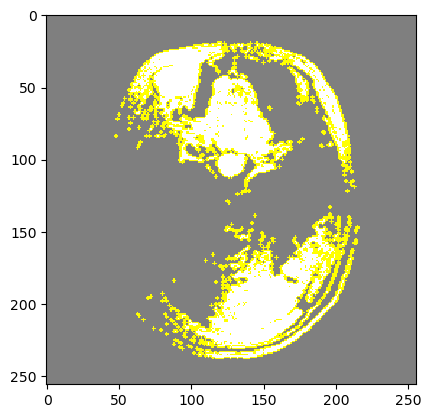

In [38]:
#plot the explantion
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), interpolation='nearest')

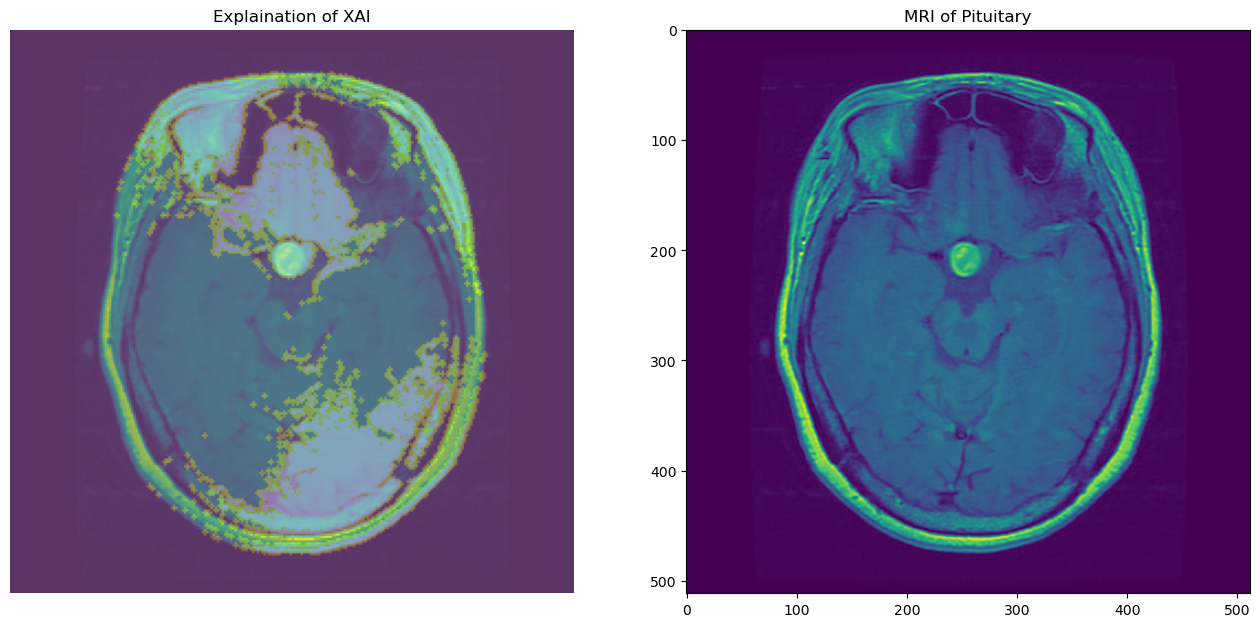

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].imshow(gray_img)
ax[0].imshow(mark_boundaries(temp / 2 + 0.5, mask), alpha=0.4)
ax[0].set_title('Explaination of XAI')
ax[0].axis('off')
ax[1].imshow(img)
ax[1].set_title('MRI of Pituitary')
plt.show()

In [40]:
def explain(model, explainer, path, steps):
    image = process_img(path)
    image = image.reshape(1, 256, 256, 3)
    
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    #prediction
    prediction = model.predict(image)
    final = np.argmax(prediction)
    classi = class_names[final]
    
    
    #read image and convert into 2D
    tem = cv2.imread(path)
    tem = cv2.resize(tem, [256,256])
    gray_img = cv2.cvtColor(tem, cv2.COLOR_BGR2GRAY)
    
    explanation = explainer.explain_instance(gray_img.astype('double'), model.predict, top_labels=4, hide_color=0, num_samples=steps)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    
    fig, ax = plt.subplots(1, 2, figsize=(16,8))
    ax[0].imshow(gray_img)
    ax[0].imshow(mark_boundaries(temp / 2 + 0.5, mask), alpha=0.4)
    ax[0].set_title('Explaination of XAI')
    ax[0].axis('off')
    ax[1].imshow(img)
    ax[1].set_title(f'MRI of {classi}')
    plt.show()

1/1 [==============================] - 0s 21ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


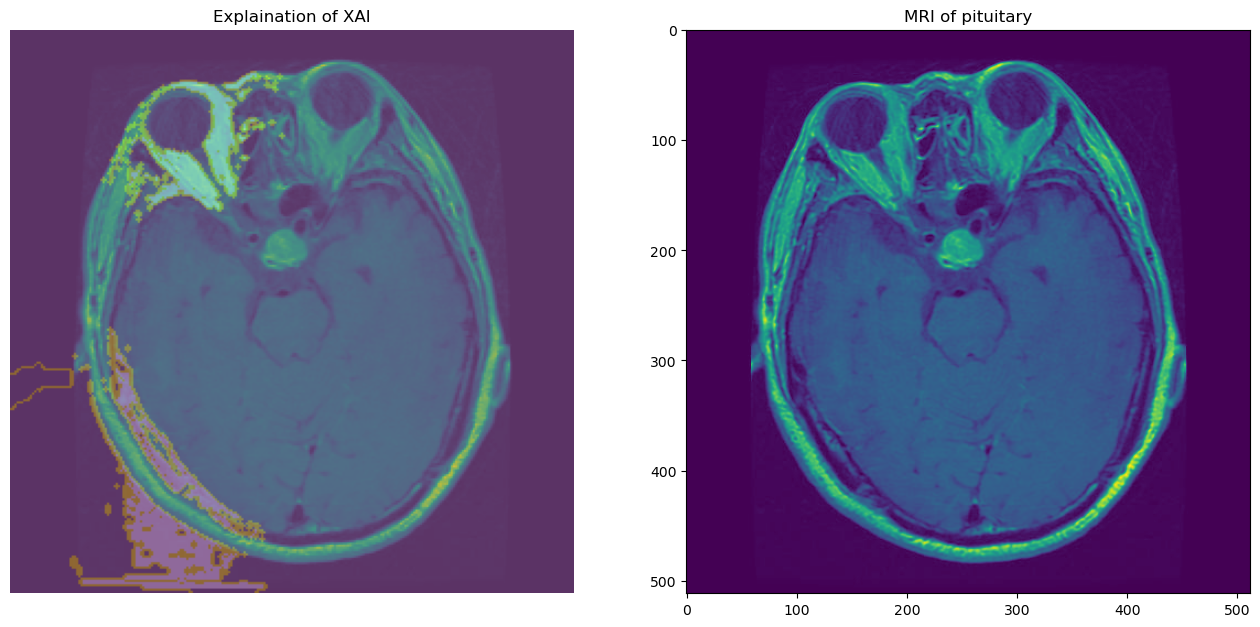

In [41]:
path = "//kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0028.jpg"
explain(model, explainer, path, 2000)

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


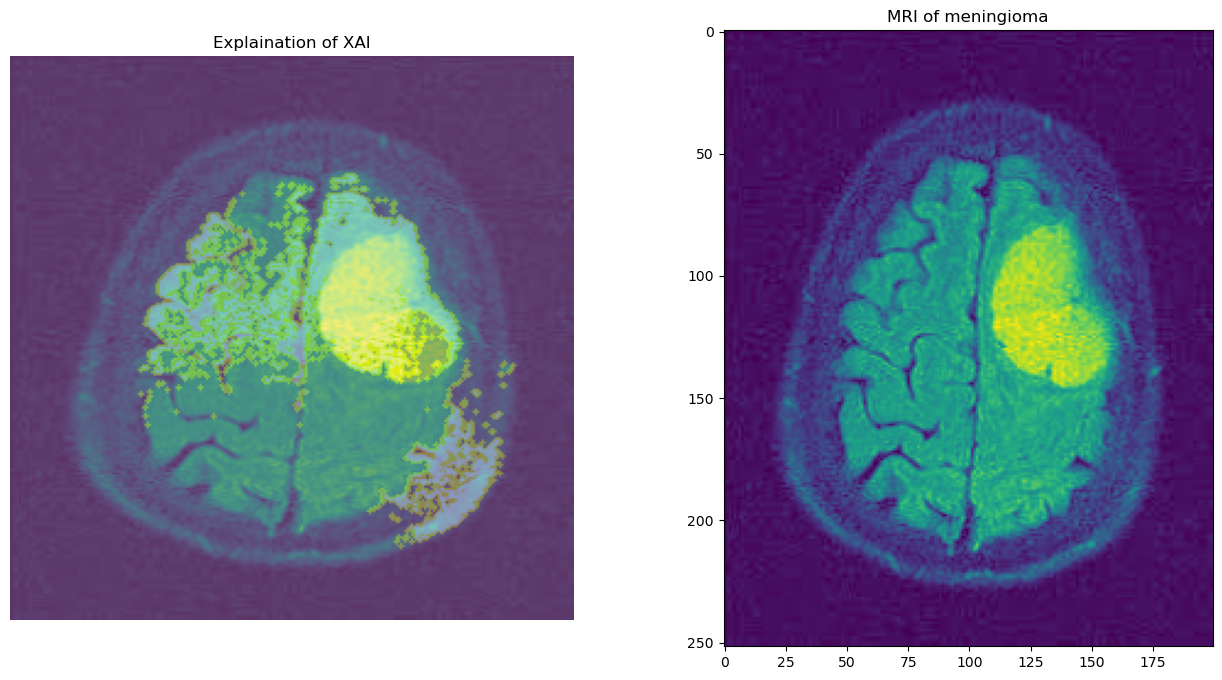

In [42]:
path = "/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0082.jpg"
explain(model, explainer, path, 2000)

1/1 [==============================] - 0s 48ms/step


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


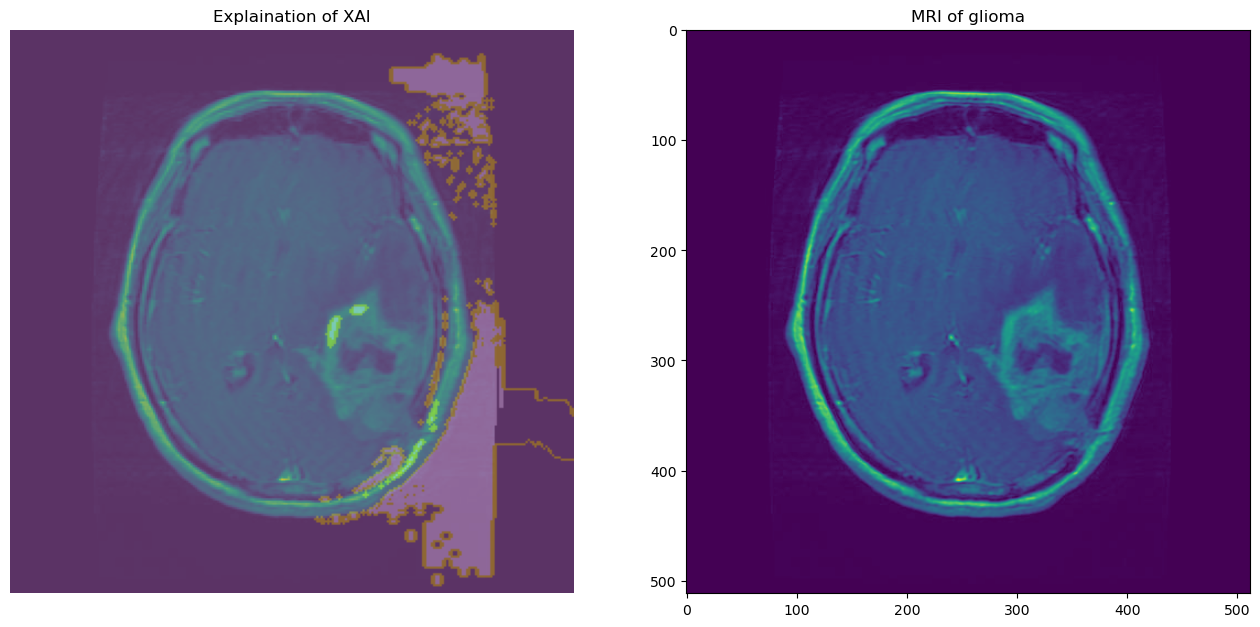

In [43]:
path = "/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0022.jpg"
explain(model, explainer, path, 1500)